# 1. 데이터 준비

In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models


Matplotlib is building the font cache; this may take a moment.


2.6.0


In [2]:
# 데이터셋 분할

DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


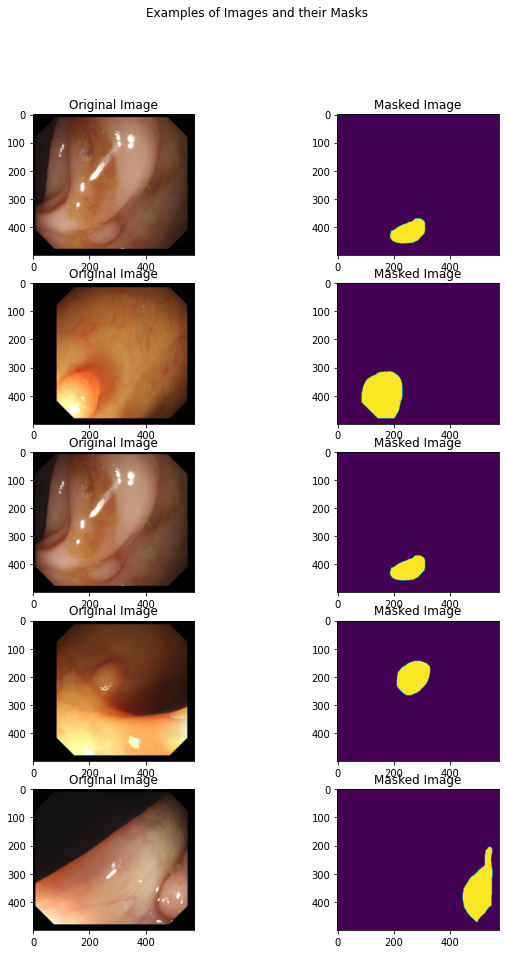

In [3]:
# 데이터 시각화
display_num = 5
r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

# 2. 데이터파이프라인 설계 및 전처리

In [4]:
# 하이퍼파라미터 설정
image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

In [5]:
# 이미지 처리 함수 정의
def _process_pathnames(fname, label_path):
    # 파일을 읽고 디코딩
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    # 이미지 크기 조정
    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    # 스케일링
    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [6]:
# 이미지 이동 함수
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

In [7]:
# 이미지 플립 함수
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

In [8]:
# 데이터 증강 함수
def _augment(img,
             label_img,
             resize=None,  # 이미지 크기 조정
             scale=1,  # 이미지 스케일 조정
             hue_delta=0.,  # RGB 이미지의 색조 랜덤 조정
             horizontal_flip=True,  # 랜덤 좌우 플립
             width_shift_range=0.05,  # 수평 이동 범위
             height_shift_range=0.05):  # 수직 이동 범위
    if resize is not None:
        # 두 이미지 크기 조정
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [9]:
# 데이터셋 생성 함수
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # 파일명과 라벨로 데이터셋 생성
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # 다중 스레드를 활용하여 전처리 함수 매핑
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train: # 학습 시에만 데이터 증강 적용
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [10]:
# 학습 및 테스트 데이터셋 생성
train_dataset = get_baseline_dataset(x_train_filenames, y_train_filenames)
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames, y_test_filenames, is_train=False)

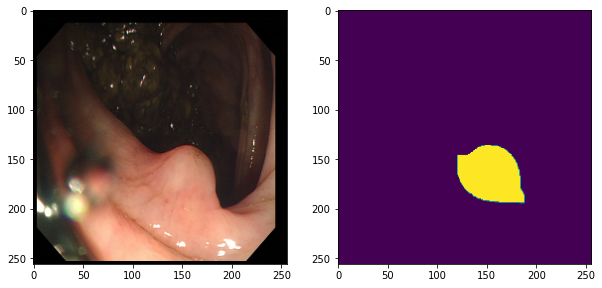

In [11]:
# 학습 데이터 시각화
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

# 3. 모델 설계

## 3-1. Encoder-Decoder 모델

In [12]:
# Encoder 구현
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [13]:
# Encoder 구조 확인
bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print("Encoder output shape:", bottleneck.shape)

Encoder output shape: (8, 16, 16, 512)


In [14]:
# Decoder 구현
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [15]:
# Decoder 구조 확인
predictions = decoder(bottleneck)
print("Decoder output shape:", predictions.shape)

Decoder output shape: (8, 256, 256, 1)


In [16]:
# Encoder-Decoder 모델 생성
ed_model = tf.keras.Sequential()
ed_model.add(encoder)
ed_model.add(decoder)

## 3-2. U-Net 모델

In [17]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [18]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

In [19]:
class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder

class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder

class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [20]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [21]:
# U-Net 모델 생성
unet_model = UNet()

## 3-3. Pretrained 모델을 인코더로 활용한 U-Net

In [22]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

In [23]:
# Pretrained VGG16 U-Net 모델 생성
vgg16_unet_model = Vgg16UNet()

58900480/58889256 [==============================] - 0s 0us/step


## 3-4. 기타 세팅

In [24]:
# 손실 함수 정의
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [25]:
# 평가 함수: Mean IoU
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # 혼동 행렬 계산
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # mean iou 계산
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [26]:
# 모델 결과 시각화 함수
def print_images(model):
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(min(batch_size, 3)):  # 최대 3개 이미지만 표시
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

In [27]:
# 세 모델 훈련 및 평가 함수
def train_and_evaluate_model(model, model_name, epochs=max_epochs):
    # 옵티마이저 및 모델 컴파일
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
    
    # 체크포인트 디렉토리 생성
    checkpoint_dir = os.path.join(DATASET_PATH, f'train_ckpt/{model_name}')
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    # 콜백 함수 설정
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='val_loss',
                                                    mode='auto',
                                                    save_best_only=True,
                                                    verbose=0)
    
    cos_decay = tf.keras.experimental.CosineDecay(1e-3, epochs)
    lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)
    
    # 모델 훈련
    history = model.fit(train_dataset,
                         epochs=epochs,
                         steps_per_epoch=num_train_examples//batch_size,
                         validation_data=test_dataset,
                         validation_steps=num_test_examples//batch_size,
                         callbacks=[cp_callback, lr_callback])
    
    # 학습 과정 시각화
    dice_loss_values = history.history['dice_loss']
    loss_values = history.history['loss']
    val_dice_loss_values = history.history['val_dice_loss']
    val_loss_values = history.history['val_loss']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss_values, label='Loss')
    plt.plot(epochs_range, dice_loss_values, label='Dice Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Train Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_loss_values, label='Val Loss')
    plt.plot(epochs_range, val_dice_loss_values, label='Val Dice Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Validation Loss')
    plt.tight_layout()
    plt.show()
    
    # 모델 체크포인트 로드
    model.load_weights(checkpoint_dir)
    
    # 모델 평가 (Mean IoU)
    mean_iou_values = []
    for images, labels in test_dataset:
        predictions = model(images, training=False)
        m = mean_iou(labels, predictions)
        mean_iou_values.append(m)
    
    mean_iou_value = np.mean(mean_iou_values)
    print(f"{model_name} Mean IoU: {mean_iou_value:.4f}")
    
    # 예측 결과 시각화
    print(f"\n{model_name} Sample Predictions:")
    print_images(model)
    
    return history, mean_iou_value

# 4. 모델 학습

## 4-1. 학습

1. Training Encoder-Decoder Model
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 13s 203ms/step - loss: 1.0881 - dice_loss: 0.7433 - val_loss: 1.4694 - val_dice_loss: 0.8757
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 7s 187ms/step - loss: 0.9322 - dice_loss: 0.7028 - val_loss: 1.3171 - val_dice_loss: 0.7832
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 7s 189ms/step - loss: 0.8821 - dice_loss: 0.6701 - val_loss: 1.3813 - val_dice_loss: 0.8077
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 7s 189ms/step - loss: 0.8352 - dice_loss: 

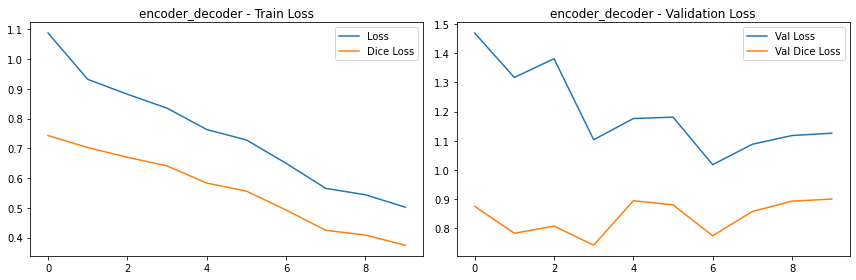

encoder_decoder Mean IoU: 0.4821

encoder_decoder Sample Predictions:


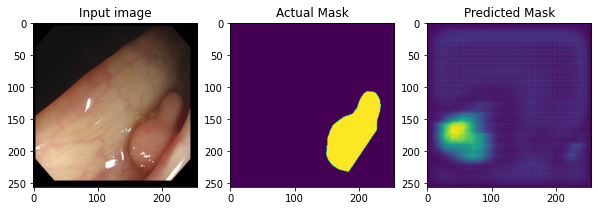

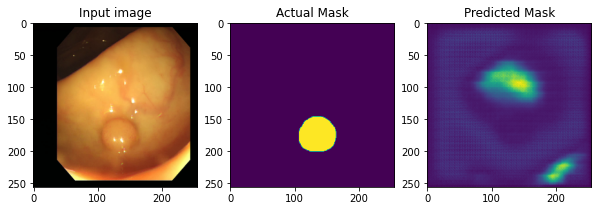

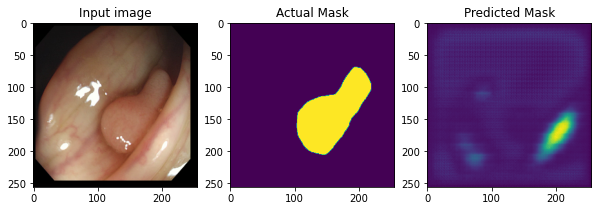


2. Training U-Net Model
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 41s 868ms/step - loss: 1.0753 - dice_loss: 0.7321 - val_loss: 9372.1807 - val_dice_loss: 0.8849
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 27s 854ms/step - loss: 0.9066 - dice_loss: 0.6895 - val_loss: 50.9469 - val_dice_loss: 1.0000
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 27s 861ms/step - loss: 0.9101 - dice_loss: 0.6965 - val_loss: 1.2392 - val_dice_loss: 0.8644
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 27s 861ms/step - loss: 0.9083 - dice_loss: 0.

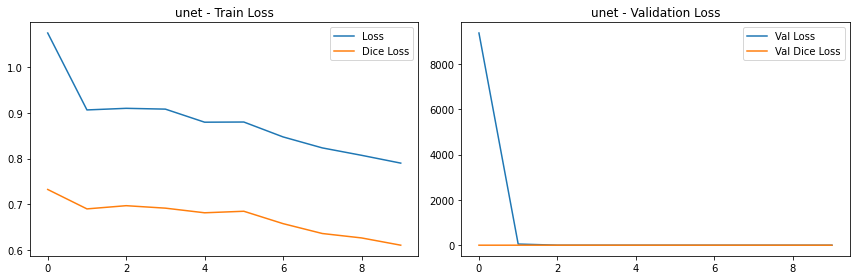

unet Mean IoU: 0.4692

unet Sample Predictions:


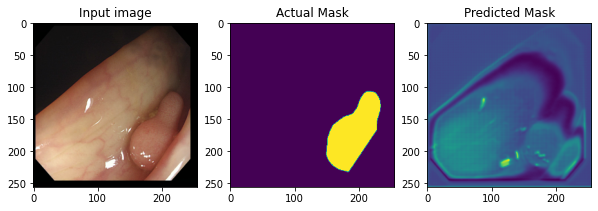

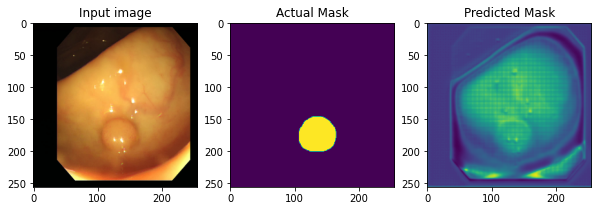

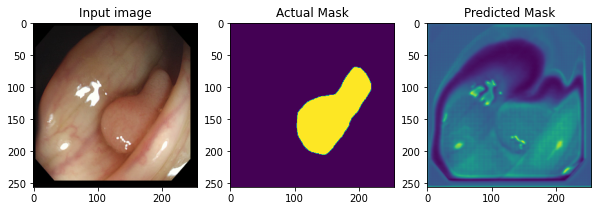


3. Training VGG16-UNet Model
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 27s 591ms/step - loss: 1.0255 - dice_loss: 0.7026 - val_loss: 14.6137 - val_dice_loss: 1.0000
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 19s 575ms/step - loss: 0.8075 - dice_loss: 0.6101 - val_loss: 1.3744 - val_dice_loss: 0.9704
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 19s 576ms/step - loss: 0.7299 - dice_loss: 0.5572 - val_loss: 1.9493 - val_dice_loss: 0.7916
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 19s 578ms/step - loss: 0.6880 - dice_loss: 

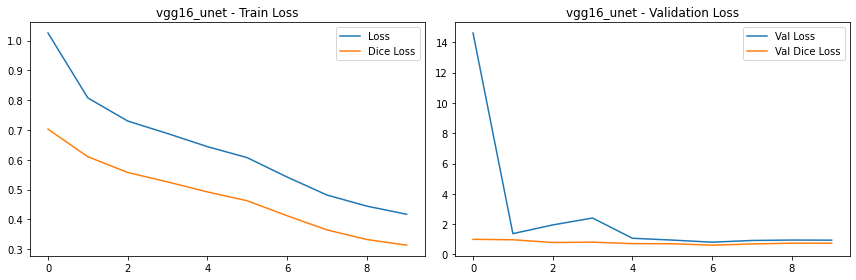

vgg16_unet Mean IoU: 0.5413

vgg16_unet Sample Predictions:


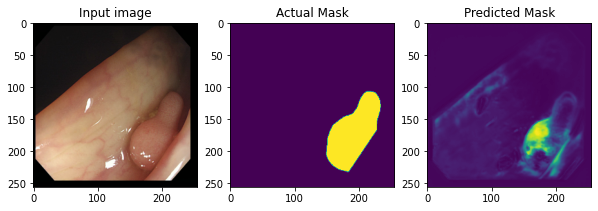

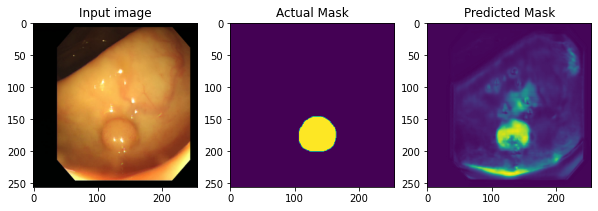

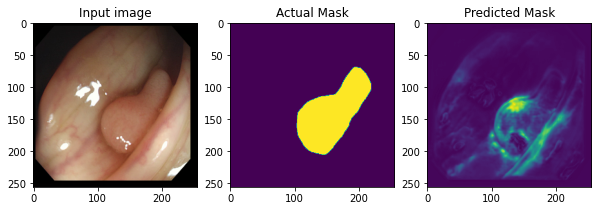

In [28]:
# 세 모델 모두 학습 및 평가
print("1. Training Encoder-Decoder Model")
ed_history, ed_miou = train_and_evaluate_model(ed_model, "encoder_decoder")

print("\n2. Training U-Net Model")
unet_history, unet_miou = train_and_evaluate_model(unet_model, "unet")

print("\n3. Training VGG16-UNet Model")
vgg_unet_history, vgg_unet_miou = train_and_evaluate_model(vgg16_unet_model, "vgg16_unet")

## 4-2. 결과 분석

**Encoder-Decoder 모델**
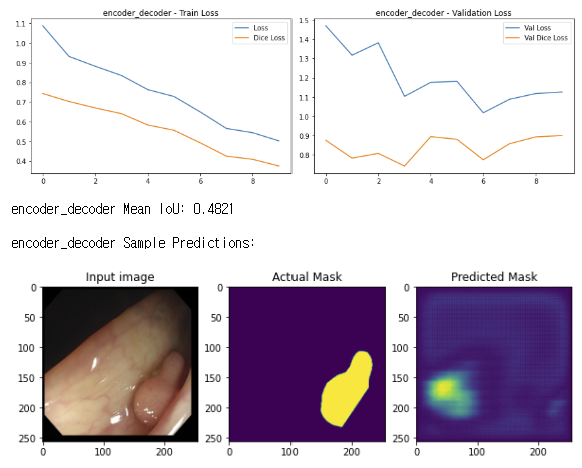


**U-Net 모델**
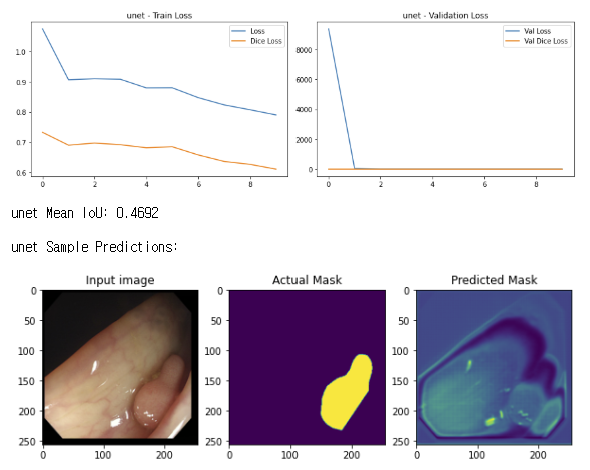

**VGG16 + U-Net 모델**
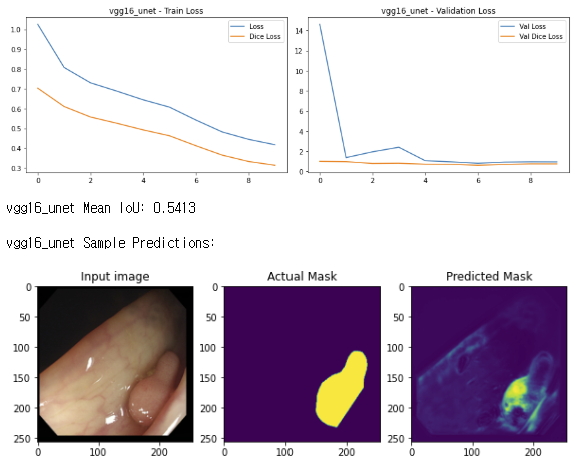

### Mean IoU 비교

- Encoder-Decoder: 0.4821
- U-Net: 0.4592
- VGG16 + U-Net: 0.5413

VGG16 + U-Net 모델이 가장 높은 Mean IoU를 보여주며,    
이는 기본 U-Net보다 약 17.9% 향상된 성능임


### 손실 함수 그래프 분석

1. Encoder-Decoder 모델:
    - 학습 손실이 지속적으로 감소하는 패턴을 보임
    - 검증 손실은 변동이 있으나 전반적으로 감소하는 경향
    - Dice Loss도 안정적으로 감소


2. U-Net 모델:
    - 학습 손실은 점진적으로 감소
    - 검증 손실은 초기에 매우 큰 값에서 급격히 감소 후 안정화
    - 검증 데이터에서의 스케일 이슈가 있어 보임


3. VGG16 + U-Net 모델:
    - 학습 손실과 Dice Loss 모두 꾸준히 감소
    - 검증 손실도 학습 초기 이후 안정적으로 유지
    - 세 모델 중 가장 안정적인 학습 패턴을 보임


### 세그멘테이션 예측 결과 분석

1. Encoder-Decoder 모델:
    - 용종의 대략적인 위치는 감지했으나 형태가 정확하지 않음
    - 경계가 불분명하고 흐릿한 예측 결과 제공


2. U-Net 모델:
    - 용종의 형태를 더 정확하게 감지하려 시도
    - 실제 마스크보다 더 넓은 영역을 예측하는 경향
    - 배경 부분에서 노이즈 존재


3. VGG16 + U-Net 모델:
    - 세 모델 중 가장 정확한 형태 예측
    - 용종의 위치와 크기를 더 정확하게 식별
    - 배경과 용종의 구분이 더 명확함
    

### 결론

1. 성능 개선 확인:
    - VGG16을 인코더로 활용한 U-Net 모델이 기본 U-Net과 Encoder-Decoder 모델보다 더 우수한 성능을 보였음. 
    - 따라서, ImageNet으로 **사전학습된 특징 추출기가 의료 이미지 세그멘테이션에도 효과적으로 역할할 수 있음**이 증명됨.


2. 모델 특성:  
    - Encoder-Decoder: 단순하지만 용종의 대략적 위치 감지 가능
    - U-Net: Skip connection을 통해 더 세밀한 예측 시도
    - VGG16 + U-Net: 사전학습된 특징 추출기와 Skip connection의 장점을 결합하여 가장 정확한 세그멘테이션 결과 제공


### 회고
- dice loss에 대해 배울 수 있었음. 두 세트 간의 유사성을 측정하는 Dice 계수를 기반으로 하며, 클래스 불균형 문제가 있는 의료 이미지 세그멘테이션에 특히 효과적임

- 일반 이미지에서 학습된 특징들도 적절한 미세 조정을 통해 의료 이미지 분석에 효과적으로 전이될 수 있다는 점을 확인했음. 의외의 배움이었고, 데이터가 제한적인 도메인에서 유용할 수 있을 것임을 느꼈음.